In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from scipy import interpolate
from scipy.signal import medfilt

/var/folders/kc/wf32p71s4kb1_phml7_l_w5r0000gp/T/ipykernel_42017/1213880579.py:4: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [5]:
truth_seq_count = pd.read_csv("../data/truth/seq_counts_truth.tsv", sep="\t")


#group by date and location

truth_seq_count['total_seq'] = truth_seq_count.groupby(['date', 'location'])['sequences'].transform('sum')
truth_seq_count['truth_freq'] = truth_seq_count['sequences']/truth_seq_count['total_seq']

#truth_set = truth_seq_count.to_numpy()


print(truth_seq_count)

            date        location variant  sequences  total_seq  truth_freq
0     2022-01-01           Japan   Delta          1          1    1.000000
1     2022-01-04           Japan   Delta          2         12    0.166667
2     2022-01-05           Japan   Delta          2         22    0.090909
3     2022-01-06           Japan   Delta          9         45    0.200000
4     2022-01-07           Japan   Delta          3         26    0.115385
...          ...             ...     ...        ...        ...         ...
1998  2022-06-25  United Kingdom   other          2        580    0.003448
1999  2022-06-26  United Kingdom   other          1        486    0.002058
2000  2022-06-28  United Kingdom   other          6       1447    0.004147
2001  2022-06-29  United Kingdom   other          1       1385    0.000722
2002  2022-06-30  United Kingdom   other         11       1278    0.008607

[2003 rows x 6 columns]


In [29]:
#sum sequences of each location and date
#m = pd.date_range(start = '2022-03-19', end = '2022-06-30' ).difference(truth_set.index)
truth_seq_count['date'] = pd.to_datetime(truth_seq_count['date'])
truth_seq_count.set_index('date',inplace=True)
dtr =pd.date_range('2022-03-19', '2022-06-30', freq='D')
s = pd.Series(index=dtr)
df2 = pd.concat([truth_seq_count,s[~s.index.isin(truth_seq_count.index)]]).sort_index()
df2 = df2.drop([0],axis=1).groupby("variant").fillna(0)
print(df2)



                  location  sequences  total_seq  truth_freq
2022-03-19             USA        1.0     1361.0    0.000735
2022-03-19           Japan        1.0        2.0    0.500000
2022-03-19             USA      599.0     1361.0    0.440118
2022-03-19  United Kingdom      551.0     9238.0    0.059645
2022-03-19             USA      728.0     1361.0    0.534901
...                    ...        ...        ...         ...
2022-06-16             USA       34.0      308.0    0.110390
2022-06-16             USA       50.0      308.0    0.162338
2022-06-16             USA       82.0      308.0    0.266234
2022-06-16             USA      141.0      308.0    0.457792
2022-06-16             USA        1.0      308.0    0.003247

[1021 rows x 4 columns]


/var/folders/w0/xfxq9pjn1ts7f3sx0vhcmh3w0000gn/T/ipykernel_21052/3515108514.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(index=dtr)


In [1]:
truth_seq_count['date'] = pd.to_datetime(truth_seq_count['date'])

dtr = pd.date_range('2022-03-19', '2022-06-30', freq='D')

# Create an empty DataFrame from selected date range
empty = pd.DataFrame(index=dtr, columns=['sequences'])

# Append your CSV file
truth_seq_count = pd.concat([truth_seq_count, empty[~empty.index.isin(truth_seq_count.index)]]).sort_index().fillna(0)

NameError: name 'pd' is not defined

In [ ]:
# Get Min Per Group
dates = truth_seq_count.groupby('sequences')['date'].min().to_frame(name='min')
# Get max from Frame
dates['max'] = truth_seq_count['date'].max()

# Create MultiIndex with separate Date ranges per Group
midx = pd.MultiIndex.from_frame(
    dates.apply(
        lambda x: pd.date_range(x['min'], x['max'], freq='MS'), axis=1
    ).explode().reset_index(name='date')[['date', 'sequences']]
)

# Reindex
truth_seq_count = (
    truth_seq_count.set_index(['date', 'sequences'])
        .reindex(midx, fill_value=0)
        .reset_index()
)

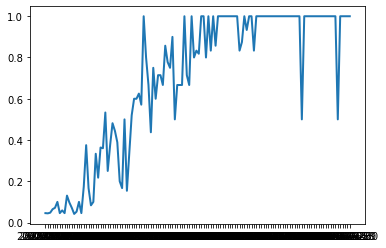

In [37]:
new_date = truth_seq_count[(truth_seq_count['location']=='Japan' ) & (truth_seq_count['variant']=='Omicron 21L')]
x = new_date['date']
y = new_date['truth_freq']
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=2.0)

In [52]:
#Smooth frequencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter  

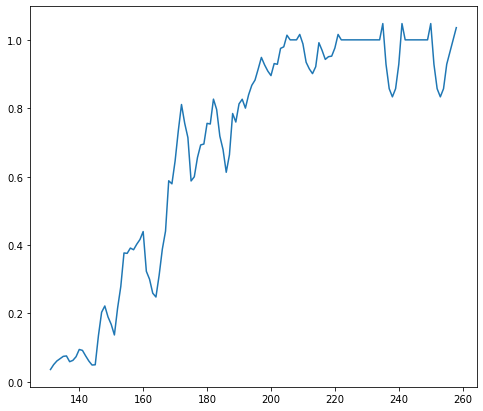

In [38]:
#Savitzky–Golay filter
#Uses convolution 
#fits low-level polynomial by the method of linear least squares

x_filtered = new_date[["truth_freq"]].apply(savgol_filter,  window_length=7, polyorder=2)
plt.figure(figsize=(8,7))

plt.ion()
plt.plot(x_filtered)
plt.show()

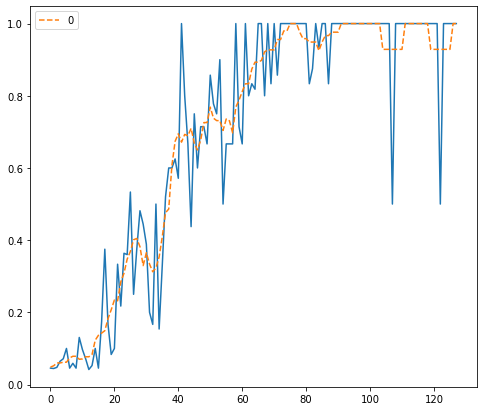

In [97]:
#uniform filter 
#take arithmetic average of neighbouring points

plt.figure(figsize=(8,7))
y = uniform_filter1d(new_date["truth_freq"], size=7, mode = "nearest")

plt.plot(np.arange(len(new_date['truth_freq'])),new_date["truth_freq"])
plt.plot(y, '--', label=f"{i}")

plt.legend()

In [47]:
#moving average smoothing


filter_length = 7
freq_mv_avg = np.convolve(new_date['truth_freq'], np.ones((filter_length)), mode = 'valid')
freq_mv_avg /= filter_length
#median filter
#freq_median_filter = medfilt(new_date['truth_freq'], filter_length)

In [80]:
new_date['moving'] = new_date.groupby('variant')['truth_freq'].transform(lambda x: x.rolling(7, 1).mean())

In [84]:
import bottleneck as bn

def rollavg_bottlneck(a,n):
    return bn.move_mean(a, window=n,min_count = None)


rollavg_bottlneck(new_date['truth_freq'],7)

array([       nan,        nan,        nan,        nan,        nan,
              nan, 0.05984533, 0.06175518, 0.06189948, 0.0737303 ,
       0.0783386 , 0.0783386 , 0.07000526, 0.07103055, 0.07691291,
       0.07691291, 0.08312409, 0.12287063, 0.13647607, 0.14242845,
       0.14919537, 0.1825287 , 0.2070911 , 0.23419443, 0.23205157,
       0.28443252, 0.30824205, 0.34752776, 0.36869178, 0.40112795,
       0.40473545, 0.38187831, 0.32949735, 0.36521164, 0.33361823,
       0.31245421, 0.32324786, 0.35340659, 0.41054945, 0.47602564,
       0.48622972, 0.60710884, 0.67377551, 0.69472789, 0.67151361,
       0.69294218, 0.68937075, 0.70977891, 0.66896259, 0.64991497,
       0.67712585, 0.72573696, 0.72573696, 0.7685941 , 0.73798186,
       0.73117914, 0.73117914, 0.70396825, 0.73571429, 0.73061224,
       0.69727891, 0.76870748, 0.7877551 , 0.81156463, 0.83320965,
       0.83320965, 0.87402597, 0.89307359, 0.89307359, 0.8978355 ,
       0.92164502, 0.92721088, 0.92721088, 0.92721088, 0.95578

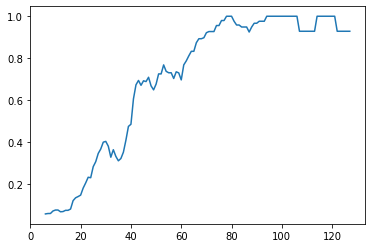

In [87]:
#plt.plot(new_date['truth_freq'])
plt.plot(rollavg_bottlneck(new_date['truth_freq'],7))